<a href="https://colab.research.google.com/github/hillbig/medical-ai-course-materials/blob/master/source/source/notebooks/Basenji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![colab-logo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/Basenji.ipynb)

# 実践編：ディープラーニングを使った配列解析

近年，次世代シーケンサ（NGS; Next Generation Sequencer）の発展により，遺伝子の塩基配列を高速，大量，安価に読み取ることができるようになってきました．

ここではディープラーニングを用いて，DNA配列からエピジェネティックな影響や転写制御を予測する問題に取り組みます．この予測モデルを使うことで，ある遺伝子変異が遺伝子発現にどのような影響を与えるのかを予測することができるようになります．







## 環境

ここで用いるライブラリは


*  Chainer
*  Cupy
*  matplotlib

です．Google Colab上では，以下のようにしてインストールすることができます．以下のセルを実行（Shit+Enter）してください．


In [3]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2
!pip install cupy-cuda92 --pre
!pip install chainer --pre

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-npp-dev-9-2
  cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
The following NEW packages will be installed:
  cuda-cublas-dev-9-2 cuda-cufft-dev-9-2 cuda-curand-dev-9-2
  cuda-cusolver-dev-9-2 cuda-cusparse-dev-9-2 cuda-libraries-dev-9-2
  cuda-npp-dev-9-2 cuda-nvgraph-dev-9-2 cuda-nvrtc-dev-9-2
0 upgraded, 9 newly installed, 0 to remove and 5 not upgraded.
Need to get 332 MB of archives.
After this operation, 972 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cublas-dev-9-2 9.2.148.1-1 [50.4 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  cuda-cufft-dev-9-2 9.2.148-1 [106 MB]
Get:3 https://developer.download.nvidia.com/compute/cuda/

インストールが完了したら，以下のセルを実行して，各ライブラリのバージョンを確認してください．



In [4]:
import chainer
import cupy
import matplotlib

chainer.print_runtime_info()
print('matplotlib:', matplotlib.__version__)

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.0.0a1
NumPy: 1.14.6
CuPy:
  CuPy Version          : 6.0.0a1
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
('matplotlib:', '2.1.2')


以下のように表示されたら成功です．（実行時期によってバージョンは以下の例よりも上がっている可能性があります）．
```
Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.0.0a1
NumPy: 1.14.6
CuPy:
  CuPy Version          : 6.0.0a1
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available
('matplotlib:', '2.1.2')
```

## 配列解析について

次世代シーケンサの発展・普及とともに，大量の遺伝子配列が読み取られるようになりました．そうした中で，塩基配列で表現された遺伝子型と病気や形態などの表現型との関係を推定するようなGWAS（Genome Wide Association Study; ゲノムワイド関連解析）がされてきましたが，遺伝子変異だけでは全ての表現型の変化を説明できないことがわかってきています．特に，非翻訳領域が遺伝子発現に影響を与え，表現型の変化を生じさせていることが様々な実験結果からわかってきています．遺伝子発現時に周辺領域がどのように影響を与えているのかを調べるために様々な手法が提案されています．（以下図）

![代替テキスト](https://www.encodeproject.org/images/c45f4d8c-0340-4fcb-abe3-e4ff0bb919be/@@download/attachment/EncodeDatatypes2013-7.png)[Encode Projectより引用]

例えば，ChIP-Seq（クロマチン免疫沈降）は，転写調節因子やそのほかのタンパク質が直接の相互作用を起こすDNAの特定部位を分離し，それらをシーケンシングして同定し，どの程度出現していたかを定量化します．これにより，タンパク質のDNA中の結合部位を正確かつ効率的に同定することができます．

このような技術で抽出された配列を学習データとして利用し，DNA配列のみからそこが結合部位かどうかだけでなく，どの程度，出現していたのかというカバレッチ値を推定することで，DNA配列のみから，転写因子，クロマチンアクセシビリティ，ヒストン修飾を予測することができるようになり，様々な遺伝子変異に対する有益な洞察を与えてくれます．

一方で，DNA配列中のどの領域がそのような特徴を持つのかを調べるためには非常に遠距離のDNA配列もいる必要があり，これが機械学習による解析を困難としていました．今回紹介する手法はこのような遠距離の関係を捉えるため，10万超の長さのDNA配列を入力として受け取り，128bpごとにその領域がどの程度各手法で発現していたのか，カバレッジ値を予測するタスクを考えます．

## データセット

ここでは，データセットとして[FANTOM5](http://fantom.gsc.riken.jp/5/)のCAGEデータセットを利用します．ここでは前処理が既に終わって配列と，各位置ごとの推定カバレッジ値が記録されたデータを利用します．下のセルを実行してデータをダウンロードしてください．



In [5]:
!wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/seq.h5

--2018-11-19 10:08:09--  https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/seq.h5
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2018-11-19 10:08:09 ERROR 404: Not Found.



In [7]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = "18yBvVVdKY1VKOYFXZuc9JAsblVXXcLnA"
drive_file = drive.CreateFile({'id': file_id})

drive_file.GetContentFile("seq.h5")
!ls -l

total 575032
-rw-r--r-- 1 root root      2568 Nov 19 10:09 adc.json
drwxr-xr-x 2 root root      4096 Nov 15 19:33 sample_data
-rw-r--r-- 1 root root 588818546 Nov 19 10:09 seq.h5




```
total 3640080
-rw-r--r-- 1 root root       2597 Oct 17 05:38 adc.json
-rw-r--r-- 1 root root 3727429632 Oct 17 05:39 data.h5
drwxr-xr-x 2 root root       4096 Oct 15 20:47 sample_data
```


In [0]:
!ls -lh

total 3.5G
-rw-r--r-- 1 root root 2.6K Nov  6 07:40 adc.json
-rw-r--r-- 1 root root 3.5G Nov  6 08:23 data.h5
drwxr-xr-x 2 root root 4.0K Nov  6 08:26 out
drwxr-xr-x 2 root root 4.0K Nov  2 17:32 sample_data


data.h5というファイルが正しくダウンロードされているかを確認してください．

data.h5はHDF5形式でデータを格納したファイルです．HDF5ファイルは，ファイルシステムと同様に，階層的にデータを格納することができ，行列やテンソルデータをそれぞれの位置で名前付きで格納することができます．

HDF5形式のファイルを操作するためにh5pyというライブラリがあります．h5pyのFile()でファイルを開き，keys()というAPIでその中に含まれているキーを列挙します．取得したキーを使って格納されている各データを参照することができます．

テンソルデータはnumpyと同様にshapeという属性でそのサイズを取得することができます．

以下のセルを実行して格納されているデータを確認してください．

In [8]:
import h5py
import numpy as np

with h5py.File('seq.h5', 'r') as hf:
  for key in hf.keys():
    print(key, hf[key].shape, hf[key].dtype)

(u'pool_width', (), dtype('int64'))
(u'target_ids', (3,), dtype('S14'))
(u'target_labels', (3,), dtype('S1'))
(u'target_strands', (3,), dtype('S1'))
(u'test_in', (444, 131072, 4), dtype('bool'))
(u'test_out', (444, 1024, 3), dtype('<f2'))
(u'test_out_full', (444, 1024, 3), dtype('<f2'))
(u'train_in', (6240, 131072, 4), dtype('bool'))
(u'train_out', (6240, 1024, 3), dtype('<f2'))
(u'valid_in', (338, 131072, 4), dtype('bool'))
(u'valid_out', (338, 1024, 3), dtype('<f2'))




```
pool_width () int64
target_ids (3,) |S14
target_labels (3,) |S1
target_strands (3,) |S1
test_in (444, 131072, 4) bool
test_out (444, 1024, 3) float16
test_out_full (444, 1024, 3) float16
train_in (6240, 131072, 4) bool
train_out (6240, 1024, 3) float16
valid_in (338, 131072, 4) bool
valid_out (338, 1024, 3) float16
```



h5py形式のファイルをnumpyデータとして扱うには，コピーする必要があります．以下のコードは'train_in'というキーに対応するテンソルデータをnumpyデータとして読み出し，そのデータを一部を表示します．

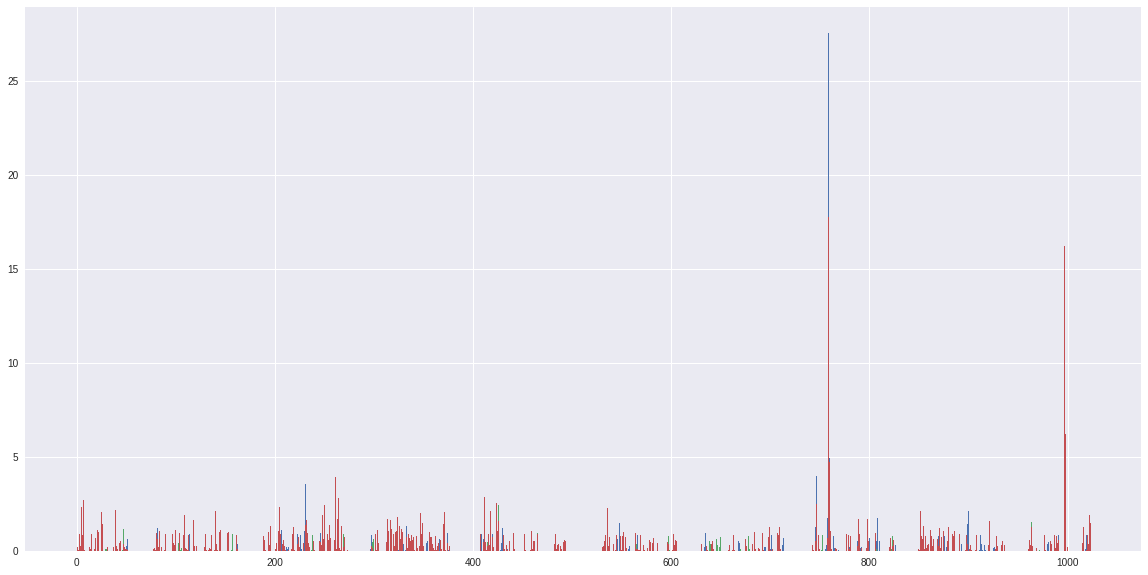

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

with h5py.File('seq.h5') as hf:
  y = hf['train_out'][:100]
  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 20
  fig_size[1] = 10
  for i in range(3):
    plt.bar(range(y.shape[1]), y[0,:,i])

## Dilated Convolutionを用いた解析

### 配列解析の戦略

配列データを扱うためには大きく３つの戦略があります．

一つ目は，配列中の順序情報は捨てて，配列をその特徴の集合とみなすことです．これはBag of Words（BoW）表現とよびます．このBoW表現は特徴に十分情報が含まれていれば強力な手法ですがDNA配列のような4種類の文字からなる配列やその部分配列だけではその特徴を捉えることは困難です．

二つ目は配列中の要素を左から右に順に読み込んでいき計算していく手法です．これはRNNを用いて解析します．このRNNの問題点はその計算が逐次的であり計算量が配列長に比例するという点です．現在の計算機は計算を並列化することで高速化を達成していますがRNNは計算を並列化することが困難です．もう一つの問題は遠距離間の関係を捉えることが難しいという点です．RNNはその計算方式から，計算の途中結果を全て状態ベクトルに格納する必要があります．遠距離間の関係を捉えようとすると，多くの情報を覚えておかなければなりませんが状態ベクトルサイズは有限なので，多くの情報を忘れなければなりません．

三つ目は配列データを1次元の画像とみなし，画像処理の時と同様にCNNを用いて解析する手法です．CNNはRNNの場合と違って各位置の処理を独立に実行できるため並列に処理することができます．また，後述するDilated Convolutionを使うことで各位置の処理は遠距離にある情報を直接読み取ることができます．次の章でDilated Convolutionについてさらに詳しくみていきます．






### Dilated Convolution

従来の畳み込み層を使って配列解析をする場合を考えてみます．
以下の図のようにある位置の入力の情報は各層で隣接する位置からしか読み込まれません．どのくらい離れた位置から情報を取得するかはカーネルサイズによって決定され，カーネルサイズがKの時，Dだけ離れた距離にある情報を取得するためにはD/K層必要となります．今回の問題の場合Dは数百から数万，Kは3や5といった値ですので必要な層数も百から万といった数になってしまい現実的ではありません．

![convolution](http://musyoku.github.io/images/post/2016-09-17/naive_conv.png)

それに対し，Dilated Convolution（atrous convolutionやconvolution weith holesともよばれます）は読み取る場所をずらしたところからうけとります．例えばDilation=4の場合，4だけ離れた位置から情報を受け取ります．このDilatedを倍々にしていき，カーネルサイズを2とした場合，Dだけ離れた位置の情報を受取るには log_2 D層だけ必要になります．今回のDが数百から数万の場合，10から20層程度あれば済むことになります．

今回はこのDilated Convolutionを使うことで遠距離にある情報を考慮できるモデルを作成します．

![dilated convolution](http://musyoku.github.io/images/post/2016-09-17/dilated_conv.png)

### ブロック

それでは最初に，ネットワークの全体を設計します．
このネットワークは二つのブロックから構成されます．

一つのブロックは長さが2^17から配列を長さが2^10のベクトル列まで圧縮することを担当します．このブロックによる変換後，得られた特徴ベクトルは1つの位置が128bpに対応します．この圧縮はSqueezeBlockが担当します．

二つ目のブロックは遠距離にある情報を考慮して各ベクトルの値を後進していく部分を担当します．パラメータDilatedを倍々にしていき，毎回2倍遠くの情報が伝搬されるようにします．この変換はDilated Blockが担当します．

以下のコードを実行してみましょう．


In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import cupy as cp

default_squeeze_params = [
  # out_ch, kernel, pool
  [32, 21, 2], #1 128 -> 64
  [64, 7, 4], #2  64 -> 16
  [128, 7, 4], #3  16 -> 4
  [256, 7, 4], #4  4 -> 1
]

default_dilated_params = [
# out_ch, kernel, dilated
  [256, 3, 1],
  [256, 3, 2], 
  [256, 3, 4], 
  [256, 3, 8], 
  [256, 3, 16], 
  [256, 3, 32],
  [256, 3, 64]
]


class Net(chainer.Chain):
    
  def __init__(self, squeeze_params=default_squeeze_params, dilated_params=default_dilated_params, n_targets=3):
    super(Net, self).__init__()
    self._n_squeeze = len(squeeze_params)
    self._n_dilated = len(dilated_params)
    with self.init_scope():
      in_ch = 4
      for i, param in enumerate(squeeze_params):
        out_ch, kernel, pool = param
        setattr(self, "s_{}".format(i), SqueezeBlock(in_ch, out_ch, kernel, pool))
        in_ch = out_ch
      for i, param in enumerate(dilated_params):
        out_ch, kernel, dilated = param
        setattr(self, "d_{}".format(i), DilatedBlock(out_ch, kernel, dilated))
      self.l = L.ConvolutionND(1, None, n_targets, 1)
    
  def forward(self, x):
    # x : (B, X, 4)
    xp = cp.get_array_module(x)
    h = xp.transpose(x, (0, 2, 1))
    h = h.astype(xp.float32)
                
    for i in range(self._n_squeeze):
      h = F.forget(self["s_{}".format(i)], h)
    
    for i in range(self._n_dilated):
      h = F.forget(self["d_{}".format(i)], h)

    h = self.l(h)
    h = xp.transpose(h, (0, 2, 1))
    return h

このネットワークは初期化時の引数としてRootBlockに関するパラメータと，DilatedBlockに関するパラメータを受け取ります．

それぞれ，出力チャンネル，カーネルサイズ，プーリングの三つ組からなるリストと，出力チャンネル，カーネルサイズ，dilatedサイズの三つ組からなるリストを受け取ります．

次に，ブロックの定義をします．

In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
import cupy as cp

class WNConvolutionND(L.ConvolutionND):
    def __init__(self, *args, **kwargs):
        super(WNConvolutionND, self).__init__(*args, **kwargs)
        self.add_param('g', self.W.data.shape[0])
        norm = np.linalg.norm(self.W.data.reshape(
            self.W.data.shape[0], -1), axis=1)
        self.g.data[...] = norm

    def __call__(self, x):
        norm = F.batch_l2_norm_squared(self.W) ** 0.5
        channel_size = self.W.data.shape[0]
        norm_broadcasted = F.broadcast_to(
            F.reshape(norm, (channel_size, 1, 1)), self.W.data.shape)
        g_broadcasted = F.broadcast_to(
            F.reshape(norm, (channel_size, 1, 1)), self.W.data.shape)
        return F.convolution_nd(
            x, g_broadcasted * self.W / norm_broadcasted, self.b, self.stride,
            self.pad, self.cover_all, self.dilate)

class SqueezeBlock(chainer.Chain):  
  def __init__(self, in_ch, out_ch, kernel, pool):
    super(SqueezeBlock, self).__init__()
    
    self.pool = pool
    with self.init_scope():
        pad = kernel // 2
        self.conv = WNConvolutionND(1, in_ch, out_ch*2, kernel, pad=pad, stride=pool)
      
  def forward(self, x):
    h = self.conv(x)
    h, g = F.split_axis(h, 2, 1)
    h = h * F.sigmoid(g)
    return h

class DilatedBlock(chainer.Chain):
  def __init__(self, out_ch, kernel, dilate):
    super(DilatedBlock, self).__init__()
    with self.init_scope():
      self.conv = WNConvolutionND(1, out_ch, out_ch*2, kernel, pad=dilate, dilate=dilate)
      self.conv1x1 = WNConvolutionND(1, out_ch, out_ch, 1)
      
  def forward(self, x):
    h = self.conv(x)
    h, g = F.split_axis(h, 2, 1)
    h = h * F.sigmoid(g)
    h = self.conv1x1(h)
    return h + x


SqueezeBlockは配列を縮めていき，長さ131072の配列を1024に縮めるためのブロックです．
1次元配列を扱うためConvolutionNDを使い，最初の引数で1次元配列であることを指定しています．各層は畳み込み層，BatchNormalization層，MaxPooling層，Reluから構成されます．

DilatedBlockはすでに長さ1024の長さになった配列に対し，Dilated Convolutionを使って遠距離にある情報も使って計算していく部分です．引数としてdilatedを受け取ります．Dilated Convolutionを使う場合は通常のConvolution層（今回はConvolutionNDだが，Convolution2Dも同様）の引数にdilatedを加えるだけで計算できます．

また，計算の際は入力結果に現在の結果を足しこみます．これはResNetと呼ばれるネットワークで提案された手法です．これにより，学習がしやすくなります．

それでは，試しにネットワークを構築して，そこにサンプルデータを流してみましょう．



In [14]:
import numpy as np
n = Net()
size = 131072 # 128 * 1024
batchsize = 4
x = np.empty((batchsize, size, 4), dtype=np.bool)
y = n.forward(x)
print(y.shape)

(4, 1024, 3)


```
(4, 1024, 3)
```



ここで，もともとB= 4, L=131072, C=4だった配列が計算後はB=4, L=1024, C=3の配列となりました．

今回の学習では対数ポアソン損失関数を利用します．これはモデルはポアソン分布の唯一のパラメータである平均を出力し，そのポアソン分布を学習データを使った最尤推定をします．この際，学習対象パラメータ以外は無視しています．性能評価する際には，比較がしやすいように学習パラメータに依存しない項も含めた式を利用しています．

In [0]:
import chainer.functions as F
import math
import sklearn
import numpy as np

def log_poisson_loss(log_x, t):
  loss =  F.mean(F.exp(log_x) - t * log_x) 
  t = chainer.cuda.to_cpu(t.astype(np.float32))  
  offset = F.mean(cp.array(t - t * np.ma.log(t)))
  return loss - offset

def log_r2_score(log_x, t):
  return F.r2_score(F.exp(log_x), t)

また，学習率の調整にCosineSchedulerを使います．ニューラルネットワークの学習では，徐々に学習率を小さくしていくと，より汎化性能の高い解を見つけられることがわかっています．焼きなまし法のように最初は学習率を高くして極小解にはまらないようにし，，後半は徐々に学習率を0に近づけていき収束させるというものです．
CosineSchedulerはCosine関数の0度から90度までの変化のように学習率を変化させます．また学習は初期が不安定なので最初にn_warmup回，学習率を0から初期学習率まで線形に増やしていきます．

In [0]:
from chainer import training
import numpy as np
import math

class CosineScheduler(training.Extension):

    def __init__(self, attr='lr', init_val=0.0001, n_decays=200, n_warmups=3, target=None, optimizer=None):
        self._attr = attr
        self._target = target
        self._optimizer = optimizer
        self._min_loss = None
        self._last_value = None
        self._init_val = init_val
        self._n_decays = n_decays - n_warmups
        self._decay_count = 0
        self._n_warmups = n_warmups

    def __call__(self, trainer):
        updater = trainer.updater
        optimizer = self._get_optimizer(trainer)
        epoch = updater.epoch
        if epoch < self._n_warmups:
            value = self._init_val / (self._n_warmups + 1) * (epoch + 1)
        else:
            value = 0.5 * self._init_val * (1 + math.cos(math.pi * (epoch - self._n_warmups) / self._n_decays))
        self._update_value(optimizer, value)


    def _get_optimizer(self, trainer):
        return self._optimizer or trainer.updater.get_optimizer('main')

    def _update_value(self, optimizer, value):
        setattr(optimizer, self._attr, value)
        self._last_value = value

また学習中にデータオーグメンテーションとして，確率0.5で配列を反転したり，入力を少しだけ前後にシフトするようにします．

In [0]:
import chainer
import random

class PreprocessedDataset(chainer.dataset.DatasetMixin):

    def __init__(self, xs, ys, size=131072, max_shift=3):
        self.xs = xs
        self.ys = ys
        self.size = size
        self.max_shift = max_shift

    def __len__(self):
        return len(self.xs)

    def get_example(self, i):
        # It applies following preprocesses:
        #     - Cropping
        #     - Random flip

        x = self.xs[i]
        y = self.ys[i]

        if random.randint(0, 1):
            x = x[::-1, :]
            y = y[::-1, :]

        s = random.randint(-self.max_shift, self.max_shift)
        x = np.roll(x, s, axis=0)
        return x, y

これで全部準備ができました．残りはchainerのtrainerを改造して学習するだけです．以下のコードを実行してください．30分程度で学習が完了します．時間の無い方はソースコード内のratio=20を40とかに増やしたり、n_epochsを10などにすることで、減らすことができます。

In [18]:
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
from chainer.training import extensions
from chainer import training
import h5py

ml_h5 = h5py.File('seq.h5')
print(list(ml_h5.keys()))

train_x = ml_h5['train_in']
train_y = ml_h5['train_out']

valid_x = ml_h5['valid_in']
valid_y = ml_h5['valid_out']

test_x = ml_h5['test_in']
test_y = ml_h5['test_out']

ratio = 20
train_x = train_x[:len(train_x)//ratio]
train_y = train_y[:len(train_y)//ratio]
valid_x = valid_x[:len(valid_x)//ratio]
valid_y = valid_y[:len(valid_y)//ratio]


train = PreprocessedDataset(train_x, train_y)
val = chainer.datasets.TupleDataset(valid_x, valid_y)

batchsize = 8

train_iter = chainer.iterators.SerialIterator(train, batchsize)
val_iter = chainer.iterators.SerialIterator(val, batchsize, repeat=False, shuffle=False)

model = L.Classifier(Net(), lossfun=log_poisson_loss, accfun=log_r2_score)

lr = 0.002
optimizer = chainer.optimizers.Adam(alpha=lr, beta1=0.97, beta2=0.98)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.GradientClipping(threshold=0.01))


updater = training.updaters.StandardUpdater(
  train_iter, optimizer, device=0)

n_epochs = 60
n_warmups = 5
out = "out"
trainer = training.Trainer(updater, (n_epochs, 'epoch'), out=out)
trainer.extend(CosineScheduler(attr='alpha', init_val=lr, n_decays=n_epochs, n_warmups=n_warmups), trigger=(1, 'epoch'))

trainer.extend(extensions.Evaluator(val_iter, model, device = 0))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot_object(model, 'model_epoch_{.updater.epoch}'), trigger=(1, 'epoch'))

trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger = (0.1, 'epoch'))

# trainer.extend(extensions.ProgressBar())
     
trainer.run()


[u'pool_width', u'target_ids', u'target_labels', u'target_strands', u'test_in', u'test_out', u'test_out_full', u'train_in', u'train_out', u'valid_in', u'valid_out']
epoch       main/loss   validation/main/loss  elapsed_time
1           0.834       0.269752              42.3188       
2           0.545968    0.291822              68.5781       
3           0.481299    0.267865              94.8936       
4           0.474464    0.261046              121.258       
5           0.462697    0.255512              147.634       
6           0.44257     0.244087              174.02        
7           0.411399    0.228142              200.425       
8           0.407284    0.221707              226.814       


Exception in main training loop: out of memory to allocate 176160768 bytes (total 11997091840 bytes)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/chainer/training/trainer.py", line 315, in run
    update()
  File "/usr/local/lib/python2.7/dist-packages/chainer/training/updaters/standard_updater.py", line 165, in update
    self.update_core()
  File "/usr/local/lib/python2.7/dist-packages/chainer/training/updaters/standard_updater.py", line 177, in update_core
    optimizer.update(loss_func, *in_arrays)
  File "/usr/local/lib/python2.7/dist-packages/chainer/optimizer.py", line 685, in update
    loss.backward(loss_scale=self._loss_scale)
  File "/usr/local/lib/python2.7/dist-packages/chainer/variable.py", line 963, in backward
    self._backward_main(retain_grad, loss_scale)
  File "/usr/local/lib/python2.7/dist-packages/chainer/variable.py", line 1040, in _backward_main
    func, target_input_indexes, out_grad, in_grad)
  File "/usr/local/lib/python

OutOfMemoryError: ignored

それでは学習した結果をテストデータに適用し，予測がどうなっているのかを確認してみましょう．

[0. 0. 0. ... 0. 0. 0.]


AttributeError: ignored

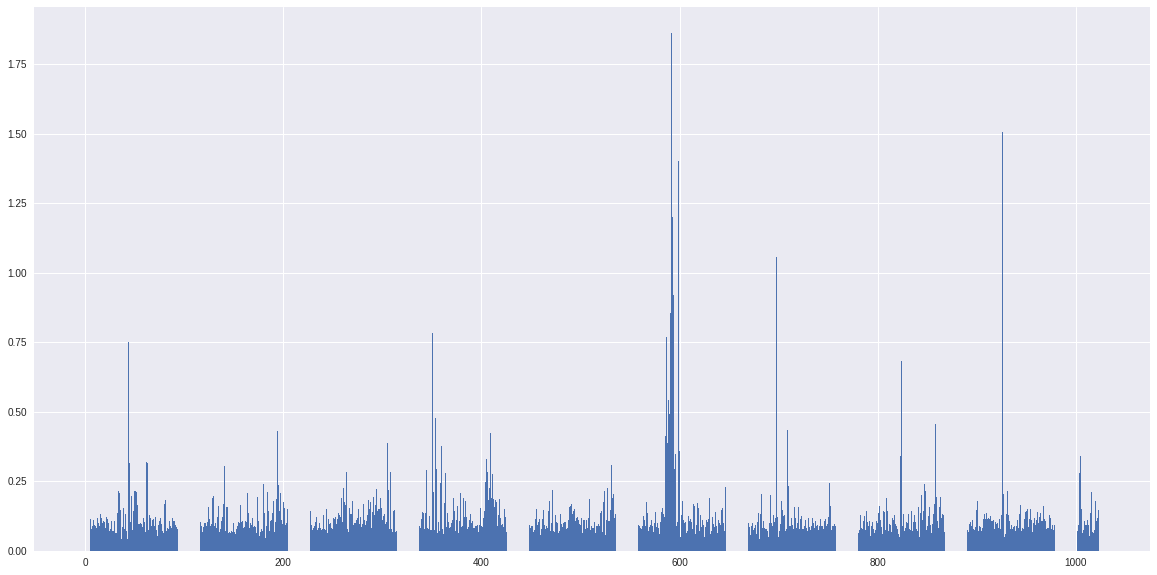

In [30]:
import chainer
import chainer.links as L
%matplotlib inline
import matplotlib.pyplot as plt

model_epoch = 7
out_dir = 'out'
model = L.Classifier(Net())
chainer.serializers.load_npz('{}/model_epoch_{}'.format(out_dir, model_epoch), model)
predictor = model.predictor

with chainer.no_backprop_mode():
  test_y_estimated = F.exp(predictor(test_x[:1]))
  
y = test_y_estimated.data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
i = 0
plt.bar(range(y.shape[1]), y[0,:,i])
plt.bar(range(y.shape[1]), test_y[0,:,i].data)



また，予測値と実際の値との差を表示してみます．
今回は学習時間の制限上，少ないデータセット（全体の1/20）で学習epoch数も60と少ないため、まだ多くのピークを捉えることができていませんが，より大きなデータセットで学習epoch数も200などと大きくして精度を改善することで多くのピークを正しく捉えられるようになります．

(1, 1024, 3)
((1024,), <type 'numpy.ndarray'>)


ValueError: ignored

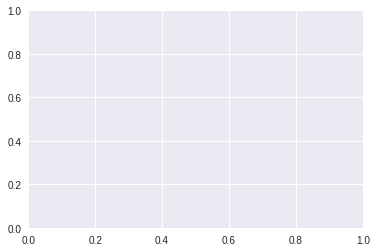

In [0]:
y = test_y_estimated.data
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20

fig_size[1] = 10
i = 0
print(type(test_y))
plt.bar(range(y.shape[1]), y[0,:,i] - test_y[0,:,i])